In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [01:16<00:00, 76.5MB/s]
100% 5.20G/5.20G [01:17<00:00, 72.5MB/s]


In [ ]:
! mkdir train



mkdir: cannot create directory ‘train’: File exists


In [ ]:
! unzip skin-cancer-mnist-ham10000.zip 

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import seaborn as sns
from torch.utils import data
import torch

In [ ]:
from PIL import Image
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
base_skin_dir=os.path.join(r'/content/drive/MyDrive/train',r'HAM10000_images_part_2')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [ ]:
print(imageid_path_dict)

{'ISIC_0028290': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028290.jpg', 'ISIC_0028321': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028321.jpg', 'ISIC_0028289': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028289.jpg', 'ISIC_0028298': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028298.jpg', 'ISIC_0028293': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028293.jpg', 'ISIC_0028282': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028282.jpg', 'ISIC_0028343': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028343.jpg', 'ISIC_0028309': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028309.jpg', 'ISIC_0028339': '/content/drive/MyDrive/train/HAM10000_images_part_2/ham10000_images_part_1/ISIC_0028339.jpg', 

In [ ]:
len(imageid_path_dict)

10015

In [ ]:
lesion_type_dict = {
'nv': 'Melanocytic nevi',
'mel': 'Melanoma',
'bkl': 'Benign keratosis-like lesions ',
'bcc': 'Basal cell carcinoma',
'akiec': 'Actinic keratoses',
'vasc': 'Vascular lesions',
'df': 'Dermatofibroma'
}

In [ ]:
df_skin = pd.read_csv(os.path.join(base_skin_dir, '/content/drive/MyDrive/finale.csv'))
df_skin['path'] = df_skin['image_id'].map(imageid_path_dict.get)
df_skin['cell_type'] = df_skin['dx'].map(lesion_type_dict.get)
df_skin['cell_type_idx'] = pd.Categorical(df_skin['cell_type']).codes
df_skin.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
500,HAM_0000502,ISIC_0029608,vasc,consensus,70,male,back,/content/drive/MyDrive/train/HAM10000_images_p...,Vascular lesions,6
935,HAM_0001922,ISIC_0031874,akiec,histo,65,female,face,/content/drive/MyDrive/train/HAM10000_images_p...,Actinic keratoses,0
98,HAM_0003007,ISIC_0028080,bkl,histo,40,female,abdomen,/content/drive/MyDrive/train/HAM10000_images_p...,Benign keratosis-like lesions,2
482,HAM_0001852,ISIC_0033749,vasc,histo,80,male,lower extremity,/content/drive/MyDrive/train/HAM10000_images_p...,Vascular lesions,6
390,HAM_0001284,ISIC_0024972,mel,histo,75,female,ear,/content/drive/MyDrive/train/HAM10000_images_p...,Melanoma,5


In [ ]:
df_skin[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
1055,0,Actinic keratoses
620,1,Basal cell carcinoma
0,2,Benign keratosis-like lesions
225,3,Dermatofibroma
753,4,Melanocytic nevi
320,5,Melanoma
439,6,Vascular lesions


In [ ]:
df_skin['cell_type'].value_counts()

Melanocytic nevi                  174
Actinic keratoses                 162
Melanoma                          158
Basal cell carcinoma              157
Benign keratosis-like lesions     148
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64

In [ ]:
import torchvision.models as models
model_conv = models.resnet50(pretrained=True)
print(model_conv)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
print(model_conv.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [ ]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 7)

In [ ]:
print(model_conv.fc)

Linear(in_features=2048, out_features=7, bias=True)


In [ ]:
print(device)

cpu


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [ ]:
model = model_conv.to(device)
model=model_conv

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df_skin, test_size=0.1)

In [ ]:
validation_df, test_df = train_test_split(test_df, test_size=0.5)

In [ ]:
train_df = train_df.reset_index()
validation_df = validation_df.reset_index()
test_df = test_df.reset_index()

In [ ]:
len(train_df)

950

In [ ]:
len(test_df)

53

In [ ]:
len(validation_df)

53

In [ ]:
jovian.log_dataset(train_df=9013, validation_df=501, test_df=501)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Dataset logged.


In [ ]:
class Dataset(data.Dataset):            # Characterizes a dataset for PyTorch
  
  def __init__(self, df, transform=None):     # Initialization
    self.df = df
    self.transform = transform          
  
  
  def __len__(self):                    # Denotes the total number of samples
    return len(self.df)        
  
  def __getitem__(self, index):         # Generates one sample of data
    
    # Load data and get label
    X = Image.open(self.df['path'][index])
    y = torch.tensor(int(self.df['cell_type_idx'][index]))
    if self.transform:
      X = self.transform(X)
    return X, y



In [ ]:
params = {'batch_size': 4,
'shuffle': True,
'num_workers': 0}

In [ ]:
import torchvision.transforms as trf
composed = trf.Compose([trf.RandomHorizontalFlip(), trf.RandomVerticalFlip(),
trf.CenterCrop(256), trf.RandomCrop(224), trf.ToTensor(),

trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
training_set = Dataset(train_df, transform=composed)
training_generator = data.DataLoader(training_set, **params)

In [ ]:
validation_set = Dataset(validation_df, transform=composed)
validation_generator = data.DataLoader(validation_set, **params)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
max_epochs = 1
trainings_error = []
validation_error = []

for epoch in range(max_epochs):
    print('epoch:', epoch)
    count_train = 0
    trainings_error_tmp = []
    model.train()

    for data_sample, y in training_generator:
        data_gpu = data_sample.to(device)
        y_gpu = y.to(device)
        output = model(data_gpu)
        err = criterion(output, y_gpu)
        err.backward()
        optimizer.step()
        trainings_error_tmp.append(err.item())
        count_train += 1

        if count_train >= 100:
            count_train = 0
            mean_trainings_error = np.mean(trainings_error_tmp)
            trainings_error.append(mean_trainings_error)
            print('trainings error:', mean_trainings_error)
            break

    with torch.set_grad_enabled(False):
        validation_error_tmp = []
        count_val = 0
        model.eval()

        for data_sample, y in validation_generator:
            data_gpu = data_sample.to(device)
            y_gpu = y.to(device)
            output = model(data_gpu)
            err = criterion(output, y_gpu)
            validation_error_tmp.append(err.item())
            count_val += 1

            if count_val >= 10:
              count_val = 0
              mean_val_error = np.mean(validation_error_tmp)
              validation_error.append(mean_val_error)
              print('validation error:', mean_val_error)
              break

epoch: 0
trainings error: 0.9291510933637619
validation error: 0.5946928441524506
epoch: 1
trainings error: 0.865176942050457
validation error: 0.35803768374025824
epoch: 2
trainings error: 0.8052788151800633
validation error: 0.39030777141451833
epoch: 3
trainings error: 0.8089786347746849
validation error: 0.28085064962506295
epoch: 4
trainings error: 0.7526633347570896
validation error: 0.28997262120246886
epoch: 5
trainings error: 0.6659397103637457
validation error: 0.19198687002062798
epoch: 6
trainings error: 0.5523328348249197
validation error: 0.2416627187281847
epoch: 7
trainings error: 0.5805163478851318
validation error: 0.303752707852982
epoch: 8
trainings error: 0.5070017088577151
validation error: 0.1669809937477112
epoch: 9
trainings error: 0.517892180532217
validation error: 0.18666968457400798
epoch: 10
trainings error: 0.4731602552905679
validation error: 0.18285764008760452
epoch: 11
trainings error: 0.45572707369923593
validation error: 0.19829049333930016
epoch: 1

In [ ]:
jovian.log_dataset(train_err = 0.172, val_err = 0.202)

[jovian] Dataset logged.


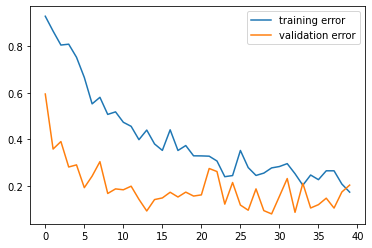

In [ ]:
plt.plot(trainings_error, label = 'training error')
plt.plot(validation_error, label = 'validation error')
plt.legend()
plt.show()



In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/df_skin1.pt")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/df_skin.pt'))



<All keys matched successfully>

In [ ]:
model.eval()
test_set = Dataset(validation_df, transform=composed)
test_generator = data.SequentialSampler(validation_set)

In [ ]:
result_array = []
gt_array = []
for i in test_generator:
  data_sample, y = validation_set.__getitem__(i)
  data_gpu = data_sample.unsqueeze(0).to(device)
  output = model(data_gpu)
  result = torch.argmax(output)
  result_array.append(result.item())
  gt_array.append(y.item())

In [ ]:
for i,j in zip(result_array,gt_array):
  print(i,j)

4 4
1 1
6 6
1 1
4 4
3 3
2 2
5 5
2 2
1 1
6 6
1 1
2 2
0 0
1 1
4 4
0 0
4 4
2 2
2 2
1 1
1 0
2 5
1 1
1 1
4 4
3 3
1 1
2 2
0 0
4 4
2 2
6 6
5 5
2 5
0 0
6 6
5 5
4 4
2 5
1 1
4 4
6 6
3 3
5 5
6 6
0 0
6 6
5 5
4 4
1 1
0 0
3 3


In [ ]:
correct_results = np.array(result_array)==np.array(gt_array)


In [ ]:
correct_results

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(result_array,gt_array)

array([[ 6,  0,  0,  0,  0,  0,  0],
       [ 1, 11,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  3,  0],
       [ 0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  5,  0],
       [ 0,  0,  0,  0,  0,  0,  7]])

In [ ]:
sum_correct = np.sum(correct_results)

In [ ]:
accuracy = sum_correct/test_generator.__len__()

In [ ]:
print(accuracy)

0.9245283018867925


# project-lbs

Use the "Run" button to execute the code.

In [1]:
!pip install jovian --upgrade --quiet


     |████▊                           | 10kB 26.5MB/s eta 0:00:01
     |█████████▌                      | 20kB 29.6MB/s eta 0:00:01
     |██████████████▎                 | 30kB 34.0MB/s eta 0:00:01
     |███████████████████             | 40kB 29.4MB/s eta 0:00:01
     |███████████████████████▊        | 51kB 28.0MB/s eta 0:00:01
     |████████████████████████████▌   | 61kB 30.2MB/s eta 0:00:01
     |████████████████████████████████| 71kB 9.1MB/s 


In [2]:
import jovian

In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="project-lbs")

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab
